### Загружаем необходимые библиотеки

In [1]:
import os
import cv2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print("Tensorflow version: ", tf.__version__)

seed = 1234
np.random.seed(seed)
tf.random.set_seed(seed)

Tensorflow version:  2.5.0


## 1. Получение данных

### 1.1. Загружаем файлы с капчей в dataset

In [2]:
# Папки с данными
data_dir = Path("data")

# Получаем список всех изображений
images = list(data_dir.glob("*.jpg"))

# Сохраним все символы в characters и characters_count
characters = set()
characters_count = []

# Список для сохранения длины капчи
captcha_length = []

# Списки для созранения названий изображений
dataset = []

for img_path in images:
    # 1. Получим название изображеня
    label = img_path.name.split(".jpg")[0]
    # 2. Сохраним длину капчи
    captcha_length.append(len(label))
    # 3. Сохраним пару изображение-название
    dataset.append((str(img_path), label))
    # 4. Сохраним имеющиеся символы
    for ch in label:
        characters.add(ch)
        characters_count.append(ch)
   
    
# Сортируем символы        
characters = sorted(characters)

# Конвертируем dataset в pd.DataFrame
dataset = pd.DataFrame(dataset, columns=["img_path", "label"], index=None)

# Перемешаем dataset
dataset = dataset.sample(frac=1.).reset_index(drop=True)


### 1.2. Проведем анализ данных

In [3]:
print("Количество найденных рисунков: ", len(images))
print("Количество уникальных символов в dataset: ", len(characters))
print("Максимальная длина капчи: ", max(Counter(captcha_length).keys()))
print("Имеющиеся символы: ", characters)
dataset.head()

Количество найденных рисунков:  237
Количество уникальных символов в dataset:  20
Максимальная длина капчи:  5
Имеющиеся символы:  ['2', '4', '5', '6', '7', '8', '9', 'б', 'в', 'г', 'д', 'ж', 'к', 'л', 'м', 'н', 'п', 'р', 'с', 'т']


,img_path,label
0,data\п4гн2.jpg,п4гн2
1,data\дннв5.jpg,дннв5
2,data\д5999.jpg,д5999
3,data\пгкпб.jpg,пгкпб
4,data\л7466.jpg,л7466


Размер рисунка:  (60, 200, 3)
Размер рисунка:  (60, 200, 3)
Размер рисунка:  (60, 200, 3)
Размер рисунка:  (60, 200, 3)


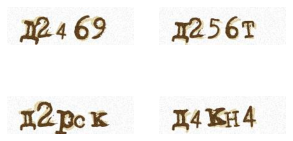

In [4]:
# Выведем несколько капч
sample_images = images[:4]

_,ax = plt.subplots(2,2, figsize=(5,3))
for i in range(4):
    #img = cv2.imread(str(sample_images[i]))
    img = cv2.imdecode(np.fromfile(sample_images[i], dtype=np.uint8), cv2.IMREAD_COLOR)
    print("Размер рисунка: ", img.shape)
    ax[i//2, i%2].imshow(img)
    ax[i//2, i%2].axis('off')
plt.show()

<BarContainer object of 20 artists>

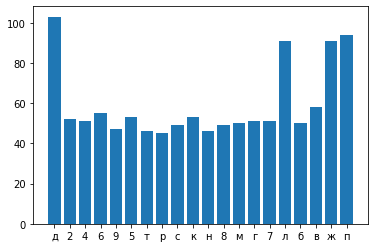

In [5]:
# Посмотрим на количественное распределение символов
cnt = Counter(characters_count)
plt.bar(cnt.keys(), cnt.values())

## 2. Подготовка данных для обучения

### 2.1. Разделим dataset на тренировочную и валидационную выборки

In [6]:
training_data, validation_data = train_test_split(dataset, test_size=0.2, random_state=seed)

training_data = training_data.reset_index(drop=True)
validation_data = validation_data.reset_index(drop=True)


### 2.2. Функции для работы с данными

In [9]:
# Получим индексы символов по их месту в списке
char_to_labels = {char:idx for idx, char in enumerate(characters)}

# Получим символы по их индексам в списке
labels_to_char = {val:key for key, val in char_to_labels.items()}


# Проверка символов в названиях капч по проверочным символам 
def is_valid_captcha(captcha):
    for ch in captcha:
        if not ch in characters:
            return False
    return True



# Сохраняем массивы в памяти, так как это не очень большой набор данных
def generate_arrays(df, resize=True, img_height=60, img_width=200):
    """Создает массив изображений и массив меток из dataframe
    
    Args:
        df: dataframe из которого мы хотим прочитать данные
        resize (bool)    : изменять размер изображений или нет
        img_weidth (int): ширина изображений с измененным размером
        img_height (int): высота изображений с измененным размером
        
    Returns:
        images (ndarray): изображения в оттенках серого
        labels (ndarray): соответствующие закодированные метки
    """
    
    num_items = len(df)
    images = np.zeros((num_items, img_height, img_width), dtype=np.float32)
    labels = [0]*num_items
    
    for i in range(num_items):
        #img = cv2.imread(df["img_path"][i])
        img =cv2.imdecode(np.fromfile(df["img_path"][i], dtype=np.uint8), cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        if resize: 
            img = cv2.resize(img, (img_width, img_height))
        
        img = (img/255.).astype(np.float32)
        label = df["label"][i]
        
        # Включим данные только в том случае, если капча действительна
        if is_valid_captcha(label):
            images[i, :, :] = img
            labels[i] = label
    
    return images, np.array(labels)

class DataGenerator(keras.utils.Sequence):
    """Создает пакеты из заданного dataset.
    
    Args:
        data: training или validation data
        labels: соответствующие метки
        char_map: сопоставление символов словаря с метками
        batch_size: размер одной партии
        img_width: ширина изображений с измененным размером
        img_height: высота изображений с измененным размером
        downsample_factor: по какому фактору CNN снизила качество изображений
        max_length: максимальная длина любой капчи
        shuffle: следует ли перетасовывать данные или нет после каждой эпохи
    Returns:
        batch_inputs: словарь, содержащий пакетные входные данные
        batch_labels: пакет соответствующих меток
    """
    
    def __init__(self,
                 data,
                 labels,
                 char_map,
                 batch_size=16,
                 img_width=200,
                 img_height=60,
                 downsample_factor=4,
                 max_length=5,
                 shuffle=True
                ):
        self.data = data
        self.labels = labels
        self.char_map = char_map
        self.batch_size = batch_size
        self.img_width = img_width
        self.img_height = img_height
        self.downsample_factor = downsample_factor
        self.max_length = max_length
        self.shuffle = shuffle
        self.indices = np.arange(len(data))    
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))
    
    def __getitem__(self, idx):
        # 1. Получим индексы следующей партии
        curr_batch_idx = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        
        # 2. В этом нет необходимости, но это может помочь нам сэкономить немного памяти,
        # так как не во всех пакетах в последнем пакете могут отсутствовать элементы
        # равные размеру пакета
        batch_len = len(curr_batch_idx)
        
        # 3. Создание экземпляров пакетных массивов
        batch_images = np.ones((batch_len, self.img_width, self.img_height, 1),
                               dtype=np.float32)
        batch_labels = np.ones((batch_len, self.max_length), dtype=np.float32)
        input_length = np.ones((batch_len, 1), dtype=np.int64) * \
                                (self.img_width // self.downsample_factor - 2) #48
        label_length = np.zeros((batch_len, 1), dtype=np.int64)
        
        
        for j, idx in enumerate(curr_batch_idx):
            # 1. Получим изображение и транспонируйте его
            img = self.data[idx].T
            # 2. Добавим дополнительное измерение
            img = np.expand_dims(img, axis=-1)
            # 3. Получите соответствующую метку
            text = self.labels[idx]
            
            # 4. Включим пару только в том случае, если капча действительна
            if is_valid_captcha(text):
                label = [self.char_map[ch] for ch in text]
                batch_images[j] = img
                batch_labels[j] = label
                label_length[j] = len(text)
        
        batch_inputs = {
                'input_data': batch_images,
                'input_label': batch_labels,
                'input_length': input_length,
                'label_length': label_length,
                }
        return batch_inputs, np.zeros(batch_len).astype(np.float32)
        
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [10]:

# Построим тренировочные данные
training_data, training_labels = generate_arrays(df=training_data)
print("Количество тренировочных изображений: ", training_data.shape)
print("Количество тренировочных меток: ", training_labels.shape)

# Построим валидационные данные
validation_data, validation_labels = generate_arrays(df=validation_data)
print("Количество валидационных изображений: ", validation_data.shape)
print("Количество валидационных меток: ", validation_labels.shape)


Количество тренировочных изображений:  (189, 60, 200)
Количество тренировочных меток:  (189,)
Количество валидационных изображений:  (48, 60, 200)
Количество валидационных меток:  (48,)


In [11]:
# Размер пакета для training и validation
batch_size = 16

# Желаемые размеры изображения
img_width=200
img_height=60 

#Коэффициент, на который изображение будет уменьшено с
# помощью сверточных блоков
downsample_factor=4

# Максимальная длина любой капчи в данных
max_length=5

# Получим объект-генератор для training data
train_data_generator = DataGenerator(data=training_data,
                                     labels=training_labels,
                                     char_map=char_to_labels,
                                     batch_size=batch_size,
                                     img_width=img_width,
                                     img_height=img_height,
                                     downsample_factor=downsample_factor,
                                     max_length=max_length,
                                     shuffle=True
                                    )

# Получим объект-генератор для validation data 
valid_data_generator = DataGenerator(data=validation_data,
                                     labels=validation_labels,
                                     char_map=char_to_labels,
                                     batch_size=batch_size,
                                     img_width=img_width,
                                     img_height=img_height,
                                     downsample_factor=downsample_factor,
                                     max_length=max_length,
                                     shuffle=False
                                    )


## 3. Установка параметров модели

### 3.1. Добавим Connectionist Temporal Classification слой, который будет возвращать loss для последовательности предсказываемых симоволов

In [12]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred, input_length, label_length):
        # Вычислим значение training-time loss и добавьте его
        # в слой с помощью `self.add_loss()`.
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        
        # Во время тестирования возвращает вычисленный loss
        return loss


### 3.2. Добавим необходимые слои нейронной сети

In [13]:

def build_model():
    # Входные данные для модели
    input_img = layers.Input(shape=(img_width, img_height, 1), name='input_data', dtype='float32')
    labels = layers.Input(name='input_label', shape=[max_length], dtype='float32')
    input_length = layers.Input(name='input_length', shape=[1], dtype='int64')
    label_length = layers.Input(name='label_length', shape=[1], dtype='int64')
    
    # Первый conv block
    x = layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal',
                       padding='same', name='Conv1')(input_img)
    x = layers.MaxPooling2D((2,2), name='pool1')(x)
    
    # Второй conv block
    x = layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal',
                       padding='same', name='Conv2')(x)
    x = layers.MaxPooling2D((2,2), name='pool2')(x)
    
    # Мы использовали два max pool с pool size и strides равным 2.
    # Следовательно, downsampled выборка в 4 раза меньше.
    # Количество фильтров в последнем слое равно 64. 
    # Изменим форму соответствующим образом, прежде чем передавать ее в RNNs
    new_shape = ((img_width // 4), (img_height // 4)*64)
    x = layers.Reshape(target_shape=new_shape, name='reshape')(x)
    x = layers.Dense(64, activation='relu', name='dense1')(x)
    x = layers.Dropout(0.2)(x)
    
    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.2))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)
    
    # Predictions
    x = layers.Dense(len(characters)+1, activation='softmax', name='dense2',
                      kernel_initializer='he_normal')(x)
    
    # Вычислим CTC
    output = CTCLayer(name='ctc_loss')(labels, x, input_length, label_length)
    
    # Определим модель
    model = keras.models.Model(inputs=[input_img, labels, input_length, label_length],
                                outputs=output, name='ocr_model_v1')
    
    # Оптимизатор
    adam = keras.optimizers.Adam(clipnorm=5)
    
    # Компилируем модель 
    model.compile(optimizer=adam)
    return model

In [15]:
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_data (InputLayer)         [(None, 200, 60, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 200, 60, 32)  320         input_data[0][0]                 
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 100, 30, 32)  0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 100, 30, 64)  18496       pool1[0][0]                      
_______________________________________________________________________________________

## 4. Обучаем модель

### 4.1. обучим на 200 эпохах

In [63]:
%%time
# Train the model
history = model.fit(train_data_generator, validation_data=valid_data_generator, epochs=200)

Epoch 1/200
12/12 [==============================] - 6s 468ms/step - loss: 0.0117 - val_loss: 0.0404
Epoch 2/200
12/12 [==============================] - 6s 478ms/step - loss: 0.0064 - val_loss: 0.0037
Epoch 3/200
12/12 [==============================] - 6s 462ms/step - loss: 0.0121 - val_loss: 0.0074
Epoch 4/200
12/12 [==============================] - 6s 507ms/step - loss: 0.0156 - val_loss: 0.0114
Epoch 5/200
12/12 [==============================] - 6s 511ms/step - loss: 0.0636 - val_loss: 0.0098
Epoch 6/200
12/12 [==============================] - 6s 495ms/step - loss: 0.0146 - val_loss: 0.0424
Epoch 7/200
12/12 [==============================] - 6s 522ms/step - loss: 0.0086 - val_loss: 0.0048
Epoch 8/200
12/12 [==============================] - 6s 532ms/step - loss: 0.0108 - val_loss: 0.0131
Epoch 9/200
12/12 [==============================] - 6s 542ms/step - loss: 0.0096 - val_loss: 0.0033
Epoch 10/200
12/12 [==============================] - 6s 494ms/step - loss: 0.0165 - val_lo

Epoch 160/200
12/12 [==============================] - 6s 500ms/step - loss: 0.0021 - val_loss: 0.0041
Epoch 161/200
12/12 [==============================] - 6s 495ms/step - loss: 0.0441 - val_loss: 8.5095e-04
Epoch 162/200
12/12 [==============================] - 6s 499ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 163/200
12/12 [==============================] - 6s 499ms/step - loss: 0.0378 - val_loss: 0.0012
Epoch 164/200
12/12 [==============================] - 5s 461ms/step - loss: 0.0163 - val_loss: 0.0099
Epoch 165/200
12/12 [==============================] - 5s 459ms/step - loss: 0.0215 - val_loss: 0.0039
Epoch 166/200
12/12 [==============================] - 5s 456ms/step - loss: 0.0412 - val_loss: 0.0085
Epoch 167/200
12/12 [==============================] - 5s 457ms/step - loss: 0.0068 - val_loss: 0.0051
Epoch 168/200
12/12 [==============================] - 6s 461ms/step - loss: 0.0072 - val_loss: 6.7507e-04
Epoch 169/200
12/12 [==============================] - 5s 459ms/s

### 4.2. Сохраняем веса модели

In [64]:
model.save_weights('ocr_model_v1.h5')

In [16]:
model.load_weights('ocr_model_v1.h5')

## 5. Предсказываем результаты на тестовой выборке

In [17]:
test_dir = Path("test")

# Получаем список всех изображений
test_images = list(test_dir.glob("*.jpg"))

test_dataset = []
          
for img_path in test_images:
    label = img_path.name.split(".jpg")[0]
    test_dataset.append((str(img_path), label))

test_dataset = pd.DataFrame(test_dataset, columns=["img_path", "label"], index=None)
# Перемешаем dataset
test_dataset = test_dataset.sample(frac=1.).reset_index(drop=True)

# Построим тестовые данные
test_data, test_labels = generate_arrays(df=test_dataset)
print("Количество тестовых изображений: ", test_data.shape)
print("Количество тестовых меток: ", test_labels.shape)

test_batch_size = len(test_labels)
# Получим объект-генератор для test data 
test_data_generator = DataGenerator(data=test_data,
                                     labels=test_labels,
                                     char_map=char_to_labels,
                                     batch_size=test_batch_size,
                                     img_width=img_width,
                                     img_height=img_height,
                                     downsample_factor=downsample_factor,
                                     max_length=max_length,
                                     shuffle=False
                                    )

Количество тестовых изображений:  (52, 60, 200)
Количество тестовых меток:  (52,)


### 5.1. Функция для декодирования выходных данных (output) сети

In [18]:
def decode_batch_predictions(pred):
    pred = pred[:, :-2] #48
    input_len = np.ones(pred.shape[0])*pred.shape[1]
    
    # Используем жадный (greedy) поиск. Для сложных задач можно использовать beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    
    # Повторим результаты и вернем текст
    output_text = []
    for res in results.numpy():
        outstr = ''
        for c in res:
            if c < len(characters) and c >=0:
                outstr += labels_to_char[c]
        output_text.append(outstr)
    
    # Вернем окончательные результаты текста
    return output_text

### 5.2. Подготовим модель для декодирования данных

In [19]:
prediction_model = keras.models.Model(model.get_layer(name='input_data').input,
                                        model.get_layer(name='dense2').output)
prediction_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_data (InputLayer)      [(None, 200, 60, 1)]      0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 200, 60, 32)       320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 100, 30, 32)       0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 100, 30, 64)       18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 50, 15, 64)        0         
_________________________________________________________________
reshape (Reshape)            (None, 50, 960)           0         
_________________________________________________________________
dense1 (Dense)               (None, 50, 64)            61504 

### 5.3. Проверяем результаты на тестовой выборке

In [20]:
true_preds = 0   
for p, (inp_value, _) in enumerate(test_data_generator):
    bs = inp_value['input_data'].shape[0]
    X_data = inp_value['input_data']
    labels = inp_value['input_label']
    
    preds = prediction_model.predict(X_data)
    pred_texts = decode_batch_predictions(preds)
    
    
    orig_texts = []
    for label in labels:
        text = ''.join([labels_to_char[int(x)] for x in label])
        orig_texts.append(text)

     
    for i in range(bs):
        print(f'Оригинальный текст: {orig_texts[i]} \t Предсказанный: {pred_texts[i]} {orig_texts[i]==pred_texts[i]}')
        if orig_texts[i]==pred_texts[i]:
            true_preds+=1
    break

print(true_preds/bs)

Оригинальный текст: пггмк 	 Предсказанный: пггмк True
Оригинальный текст: пннпб 	 Предсказанный: пннпб True
Оригинальный текст: лмжпж 	 Предсказанный: лмжпж True
Оригинальный текст: лрл76 	 Предсказанный: лрл76 True
Оригинальный текст: лжлк7 	 Предсказанный: лжлк7 True
Оригинальный текст: ждд29 	 Предсказанный: ждд29 True
Оригинальный текст: прггт 	 Предсказанный: прггт True
Оригинальный текст: лл9сп 	 Предсказанный: лл9сп True
Оригинальный текст: лвпмк 	 Предсказанный: лвпмк True
Оригинальный текст: л7к7т 	 Предсказанный: л7к7т True
Оригинальный текст: днр7б 	 Предсказанный: днр7б True
Оригинальный текст: лнжвр 	 Предсказанный: лнжвр True
Оригинальный текст: лп5м5 	 Предсказанный: лп5м5 True
Оригинальный текст: джбм9 	 Предсказанный: джбм9 True
Оригинальный текст: лвгтм 	 Предсказанный: лвгтм True
Оригинальный текст: лгдг7 	 Предсказанный: лгдг7 True
Оригинальный текст: ж6б2л 	 Предсказанный: ж6б2л True
Оригинальный текст: лн9дж 	 Предсказанный: лн9дж True
Оригинальный текст: лпмкр 	 

## 6. Выводы

### 6.1. Модель выдала 100% результат на тестовой выборке

## 7. Ссылки

7.1. https://keras.io/examples/vision/captcha_ocr/
7.2. https://www.kaggle.com/aakashnain/building-a-captcha-ocr-in-tf2-0/notebook
7.3. https://habr.com/ru/post/501436/
7.4. https://www.machinelearningmastery.ru/intuitively-understanding-connectionist-temporal-classification-3797e43a86c/
7.5. https://hackernoon.com/latest-deep-learning-ocr-with-keras-and-supervisely-in-15-minutes-34aecd630ed8
7.6. https://github.com/DeepSystems/supervisely-tutorials/blob/master/anpr_ocr/src/image_ocr.ipynb
7.7. https://www.dlology.com/blog/how-to-train-a-keras-model-to-recognize-variable-length-text/
7.8. http://www.cs.toronto.edu/~graves/icml_2006.pdf


In [ ]:
Проверка на одном изображении

In [21]:
test_img =cv2.imdecode(np.fromfile('test/д7д5м.jpg', dtype=np.uint8), cv2.IMREAD_COLOR)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
test_img = (test_img/255.).astype(np.float32)
test_img = test_img.T
# 2. Add extra dimenison
test_img = np.expand_dims(test_img, axis=-1)
test_img2 = np.expand_dims(test_img, axis=0)

In [22]:
preds = prediction_model.predict(test_img2)
pred_texts = decode_batch_predictions(preds)

In [23]:
preds.shape

(1, 50, 21)

In [24]:
pred = preds[:, :-2]
pred.shape

(1, 48, 21)

In [25]:
input_len = np.ones(pred.shape[0])*pred.shape[1]
input_len.shape

(1,)

In [26]:
results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
results

<tf.Tensor: shape=(1, 48), dtype=int64, numpy=
array([[10,  4, 10,  2, 14, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]],
      dtype=int64)>

In [27]:
output_text = []
for res in results.numpy():
    outstr = ''
    for c in res:
        if c < len(characters) and c >=0:
            outstr += labels_to_char[c]
    output_text.append(outstr)
output_text

['д7д5м']

In [28]:
pred = pred[:, :-2]
input_len = np.ones(pred.shape[0])*pred.shape[1]

# Use greedy search. For complex tasks, you can use beam search
results = keras.backend.ctc_decode(pred, 
                                    input_length=input_len,
                                    greedy=True)[0][0]

# Iterate over the results and get back the text
output_text = []
for res in results.numpy():
    outstr = ''
    for c in res:
        if c < len(characters) and c >=0:
            outstr += labels_to_char[c]
    output_text.append(outstr)